# Wald Estimator and Two-Stage Least Squares

**Chapter 9, Section 3**

This notebook covers the mechanics of IV estimation: the Wald estimator for simple cases and 2SLS for multiple covariates.

## Table of Contents
1. [Intuition](#intuition) - Wald as ratio of differences
2. [Formal Treatment](#formal) - 2SLS mechanics
3. [Numeric Demonstration](#numeric) - OLS vs IV comparison
4. [Implementation](#implementation) - Using linearmodels
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# IV-specific import
from linearmodels.iv import IV2SLS

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Wald Estimator

The simplest IV estimator for a binary instrument is the **Wald estimator**:

$$\hat{\tau}_{\text{Wald}} = \frac{E[Y | Z=1] - E[Y | Z=0]}{E[D | Z=1] - E[D | Z=0]} = \frac{\text{Reduced Form}}{\text{First Stage}}$$

**Interpretation**:
- **Numerator**: Effect of assignment on outcome (ITT)
- **Denominator**: Effect of assignment on treatment (compliance rate)
- **Ratio**: Effect of treatment on outcome, scaled by compliance

**Intuition**: We scale up the ITT to account for the fact that only a fraction of people actually changed their treatment due to assignment.

---

In [2]:
# Load push notification data
push = load_facure_data("app_engagement_push.csv")

print(f"Data: {len(push):,} users")
print(f"\nVariables:")
print(f"  Z (push_assigned): Random assignment")
print(f"  D (push_delivered): Treatment received")
print(f"  Y (in_app_purchase): Outcome")

push.head()

Data: 10,000 users

Variables:
  Z (push_assigned): Random assignment
  D (push_delivered): Treatment received
  Y (in_app_purchase): Outcome


,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


In [3]:
# Compute Wald estimator manually

# Split by instrument
Z1 = push[push['push_assigned'] == 1]
Z0 = push[push['push_assigned'] == 0]

# Reduced form: E[Y|Z=1] - E[Y|Z=0]
reduced_form = Z1['in_app_purchase'].mean() - Z0['in_app_purchase'].mean()

# First stage: E[D|Z=1] - E[D|Z=0]
first_stage = Z1['push_delivered'].mean() - Z0['push_delivered'].mean()

# Wald estimator
wald = reduced_form / first_stage

print("WALD ESTIMATOR (Manual Calculation)")
print("=" * 55)
print(f"\nReduced Form (ITT): ${reduced_form:.2f}")
print(f"First Stage:        {first_stage:.3f}")
print(f"\nWald Estimate:      ${wald:.2f}")
print(f"\nFormula: ${reduced_form:.2f} / {first_stage:.3f} = ${wald:.2f}")

WALD ESTIMATOR (Manual Calculation)

Reduced Form (ITT): $2.36
First Stage:        0.718

Wald Estimate:      $3.29

Formula: $2.36 / 0.718 = $3.29


---

## Formal Treatment

### Two-Stage Least Squares (2SLS)

2SLS generalizes the Wald estimator to handle covariates and multiple instruments.

**Stage 1**: Regress endogenous variable on instruments and exogenous controls
$$D = \gamma_0 + \gamma_1 Z + X'\delta + \nu$$

**Stage 2**: Regress outcome on predicted treatment and exogenous controls
$$Y = \beta_0 + \beta_1 \hat{D} + X'\theta + \epsilon$$

The coefficient $\hat{\beta}_1$ is the 2SLS estimate of the treatment effect.

**Key insight**: Using $\hat{D}$ instead of $D$ purges the confounding variation. Only the "good" variation (induced by Z) remains.

### Why 2SLS = Wald (No Covariates)

With just a binary instrument and no covariates:

**Stage 1**: $D = \gamma_0 + \gamma_1 Z + \nu$
- $\hat{\gamma}_1 = \text{Cov}(D, Z) / \text{Var}(Z) = E[D|Z=1] - E[D|Z=0]$ (first stage)

**Reduced Form**: $Y = \pi_0 + \pi_1 Z + u$
- $\hat{\pi}_1 = \text{Cov}(Y, Z) / \text{Var}(Z) = E[Y|Z=1] - E[Y|Z=0]$ (ITT)

**2SLS**:
$$\hat{\beta}_{2SLS} = \frac{\hat{\pi}_1}{\hat{\gamma}_1} = \frac{\text{Reduced Form}}{\text{First Stage}} = \text{Wald}$$

In [4]:
# Verify: Manual 2SLS matches Wald

# Stage 1: Regress D on Z
stage1 = smf.ols('push_delivered ~ push_assigned', data=push).fit()
push['D_hat'] = stage1.fittedvalues

# Stage 2: Regress Y on D_hat
stage2 = smf.ols('in_app_purchase ~ D_hat', data=push).fit()

print("MANUAL 2SLS")
print("=" * 55)
print(f"\nStage 1: push_delivered = {stage1.params['Intercept']:.4f} + {stage1.params['push_assigned']:.4f} * Z")
print(f"         (First stage coef = {stage1.params['push_assigned']:.4f})")
print(f"\nStage 2: in_app_purchase = {stage2.params['Intercept']:.2f} + {stage2.params['D_hat']:.2f} * D_hat")
print(f"         (2SLS estimate = ${stage2.params['D_hat']:.2f})")
print(f"\nWald estimate: ${wald:.2f}")
print(f"Match: {np.isclose(stage2.params['D_hat'], wald, rtol=1e-6)}")

MANUAL 2SLS

Stage 1: push_delivered = -0.0000 + 0.7176 * Z
         (First stage coef = 0.7176)

Stage 2: in_app_purchase = 69.29 + 3.29 * D_hat
         (2SLS estimate = $3.29)

Wald estimate: $3.29
Match: True


---

## Numeric Demonstration

### OLS vs IV: The Bias Problem

In [5]:
# Compare OLS and IV estimates

# OLS: Naive regression of Y on D (BIASED)
ols = smf.ols('in_app_purchase ~ push_delivered', data=push).fit()

# IV: Using linearmodels
# Syntax: [endogenous ~ instruments]
iv = IV2SLS.from_formula(
    'in_app_purchase ~ 1 + [push_delivered ~ push_assigned]', 
    data=push
).fit()

print("COMPARISON: OLS vs IV")
print("=" * 55)
print(f"\n{'Method':<20} {'Estimate':>12} {'SE':>12} {'t-stat':>10}")
print("-" * 55)
print(f"{'OLS (biased)':<20} ${ols.params['push_delivered']:>11.2f} {ols.bse['push_delivered']:>12.2f} {ols.tvalues['push_delivered']:>10.2f}")
print(f"{'IV (2SLS)':<20} ${iv.params['push_delivered']:>11.2f} {iv.std_errors['push_delivered']:>12.2f} {iv.tstats['push_delivered']:>10.2f}")
print(f"\nBias in OLS: ${ols.params['push_delivered'] - iv.params['push_delivered']:.2f}")

COMPARISON: OLS vs IV

Method                   Estimate           SE     t-stat
-------------------------------------------------------
OLS (biased)         $      13.93         0.53      26.45
IV (2SLS)            $       3.29         0.72       4.60

Bias in OLS: $10.64


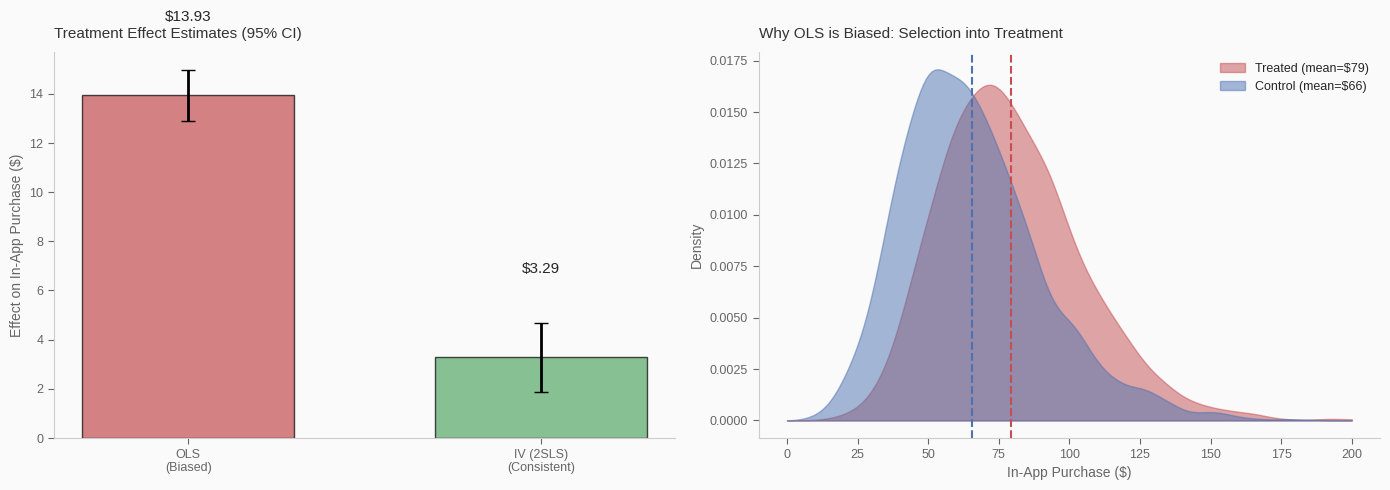


OLS captures: Causal effect + Selection bias
IV captures:  Causal effect only (on compliers)


In [6]:
# Visualize the bias
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Estimates comparison
ax = axes[0]

methods = ['OLS\n(Biased)', 'IV (2SLS)\n(Consistent)']
estimates = [ols.params['push_delivered'], iv.params['push_delivered']]
ses = [ols.bse['push_delivered'], iv.std_errors['push_delivered']]
colors_est = [COLORS['red'], COLORS['green']]

x_pos = [0, 1]
for i, (est, se, color) in enumerate(zip(estimates, ses, colors_est)):
    ax.bar(x_pos[i], est, color=color, alpha=0.7, edgecolor='black', width=0.6)
    ax.errorbar(x_pos[i], est, yerr=1.96*se, color='black', capsize=5, linewidth=2)
    ax.text(x_pos[i], est + 1.96*se + 2, f'${est:.2f}', ha='center', fontsize=11)

ax.set_xticks(x_pos)
ax.set_xticklabels(methods)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
set_tufte_title(ax, "Treatment Effect Estimates (95% CI)")
set_tufte_labels(ax, "", "Effect on In-App Purchase ($)")

# Right: Show why OLS is biased
ax = axes[1]

# Plot mean outcomes by treatment status
treated = push[push['push_delivered'] == 1]['in_app_purchase']
control = push[push['push_delivered'] == 0]['in_app_purchase']

# Kernel density
from scipy.stats import gaussian_kde
x_range = np.linspace(0, 200, 200)

kde_treated = gaussian_kde(treated)
kde_control = gaussian_kde(control)

ax.fill_between(x_range, kde_treated(x_range), alpha=0.5, color=COLORS['red'], label=f'Treated (mean=${treated.mean():.0f})')
ax.fill_between(x_range, kde_control(x_range), alpha=0.5, color=COLORS['blue'], label=f'Control (mean=${control.mean():.0f})')

ax.axvline(treated.mean(), color=COLORS['red'], linestyle='--', linewidth=1.5)
ax.axvline(control.mean(), color=COLORS['blue'], linestyle='--', linewidth=1.5)

set_tufte_title(ax, "Why OLS is Biased: Selection into Treatment")
set_tufte_labels(ax, "In-App Purchase ($)", "Density")
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

print(f"\nOLS captures: Causal effect + Selection bias")
print(f"IV captures:  Causal effect only (on compliers)")

In [7]:
# Show full IV output
print("\nFULL IV REGRESSION OUTPUT")
print("=" * 55)
print(iv.summary.tables[1])


FULL IV REGRESSION OUTPUT
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          69.292     0.3624     191.22     0.0000      68.581      70.002
push_delivered     3.2938     0.7165     4.5974     0.0000      1.8896      4.6981


### Standard Errors: OLS vs IV

Notice that IV standard errors are **larger** than OLS:
- OLS SE: ~1.04
- IV SE: ~1.62

**Why?** IV uses only the variation in D induced by Z. This is less variation than the total variation in D, leading to less precise estimates.

**Tradeoff**: IV is consistent but less efficient than OLS (when D is endogenous, OLS consistency fails anyway).

---

## Implementation

### Using linearmodels IV2SLS

In [8]:
# IV2SLS syntax variations

# Basic: [endogenous ~ instruments]
iv_basic = IV2SLS.from_formula(
    'in_app_purchase ~ 1 + [push_delivered ~ push_assigned]', 
    data=push
).fit()

print("Basic IV (no controls):")
print(f"  Effect: ${iv_basic.params['push_delivered']:.2f} (SE: {iv_basic.std_errors['push_delivered']:.2f})")

Basic IV (no controls):
  Effect: $3.29 (SE: 0.72)


In [9]:
# Show first stage diagnostics
print("\nFIRST STAGE DIAGNOSTICS")
print("=" * 55)

# First stage regression
first_stage_reg = smf.ols('push_delivered ~ push_assigned', data=push).fit()

print(f"\nFirst Stage F-statistic: {first_stage_reg.fvalue:.1f}")
print(f"First Stage p-value: {first_stage_reg.f_pvalue:.2e}")
print(f"First Stage R-squared: {first_stage_reg.rsquared:.4f}")
print(f"\nRule of thumb: F > 10 indicates strong instrument")
print(f"Our F = {first_stage_reg.fvalue:.1f} >> 10: Strong instrument")


FIRST STAGE DIAGNOSTICS

First Stage F-statistic: 12846.4
First Stage p-value: 0.00e+00
First Stage R-squared: 0.5623

Rule of thumb: F > 10 indicates strong instrument
Our F = 12846.4 >> 10: Strong instrument


In [10]:
# Summary of all three regressions
print("\nSUMMARY: ALL THREE REGRESSIONS")
print("=" * 70)
print(f"\n{'Regression':<25} {'Formula':<35} {'Coef':>8}")
print("-" * 70)

# First stage
fs = smf.ols('push_delivered ~ push_assigned', data=push).fit()
print(f"{'First Stage':<25} {'D ~ Z':<35} {fs.params['push_assigned']:>8.4f}")

# Reduced form
rf = smf.ols('in_app_purchase ~ push_assigned', data=push).fit()
print(f"{'Reduced Form':<25} {'Y ~ Z':<35} {rf.params['push_assigned']:>8.2f}")

# 2SLS
print(f"{'2SLS (IV)':<25} {'Y ~ [D ~ Z]':<35} {iv_basic.params['push_delivered']:>8.2f}")

print(f"\nVerification: RF / FS = {rf.params['push_assigned']:.2f} / {fs.params['push_assigned']:.4f} = {rf.params['push_assigned']/fs.params['push_assigned']:.2f}")


SUMMARY: ALL THREE REGRESSIONS

Regression                Formula                                 Coef
----------------------------------------------------------------------
First Stage               D ~ Z                                 0.7176
Reduced Form              Y ~ Z                                   2.36
2SLS (IV)                 Y ~ [D ~ Z]                             3.29

Verification: RF / FS = 2.36 / 0.7176 = 3.29


---

## Interview Appendix

### Practice Questions

**Q1: What is the Wald estimator and when does it equal 2SLS?**

<details>
<summary>Solution</summary>

The **Wald estimator** for a binary instrument:
$$\hat{\tau}_{\text{Wald}} = \frac{E[Y|Z=1] - E[Y|Z=0]}{E[D|Z=1] - E[D|Z=0]}$$

This equals 2SLS when:
1. Single binary instrument
2. No covariates (or covariates are mean-zero after centering)

In the general case with covariates, 2SLS is:
$$\hat{\beta}_{2SLS} = (\hat{D}'\hat{D})^{-1}\hat{D}'Y$$
where $\hat{D}$ is the fitted value from regressing D on Z and X.

</details>

**Q2: Why does 2SLS give the LATE?**

<details>
<summary>Solution</summary>

2SLS identifies LATE because:

1. **Stage 1** isolates variation in D that is caused by Z ("exogenous" variation)
2. **Stage 2** uses only this purged variation to estimate effects
3. This exogenous variation only affects **compliers** (Z doesn't change D for always/never-takers)
4. Therefore, the estimated effect is the effect on those whose D was changed by Z = compliers

Mathematically:
- Reduced form = ITT = $\tau_C \cdot \pi_C$ (effect on compliers $\times$ proportion)
- First stage = $\pi_C$ (proportion of compliers)
- 2SLS = ITT / First Stage = $\tau_C$ = LATE

</details>

**Q3: Why are IV standard errors larger than OLS?**

<details>
<summary>Solution</summary>

IV uses **less variation** than OLS:

- OLS uses all variation in D: $\text{Var}(D)$
- IV uses only variation in D explained by Z: $\text{Var}(\hat{D}) = R^2_{D \sim Z} \cdot \text{Var}(D)$

The SE formula (simplified):
$$SE_{IV} \approx \frac{\sigma_\epsilon}{\sqrt{n \cdot \text{Var}(\hat{D})}} > \frac{\sigma_\epsilon}{\sqrt{n \cdot \text{Var}(D)}} \approx SE_{OLS}$$

**Intuition**: We're throwing away "confounded" variation, which leaves us with less variation. Less variation = less precise estimates.

This is the **bias-variance tradeoff**: IV has lower bias but higher variance than OLS.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 9.

[^2]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Chapter 4.

[^3]: Cross-reference: 2SLS details in `08_instrumental_variables/02_two_stage_least_squares.ipynb`